In [1]:
import sagemaker
from sagemaker.pytorch import PyTorch


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

import warnings

import torch
import torch.nn as nn
import torch.optim as optim
import boto3
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
import timm  # For EfficientNet models

from io import StringIO
from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.12/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# loaidng in the training csv to use in our model.
df = pd.read_csv('s3://birdclef-2025/train.csv')
df.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


In [3]:
# Function to display spectrograms
def show_spectrograms(spec_arrays, num_items, num_rows, num_cols):
    fig = plt.figure(figsize=(16, 8))    
    indices = range(min(num_items, len(spec_arrays)))
    
    for index, img_index in enumerate(indices):
        if index >= num_rows * num_cols:
            break
            
        img = spec_arrays[img_index]
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        
        # Handle different array formats
        if isinstance(img, np.ndarray):
            # For spectrograms that are 3D (channels, height, width)
            if len(img.shape) == 3 and img.shape[0] <= 3:
                img = img.transpose(1, 2, 0)
                
            # Use a good colormap for spectrograms
            im = ax.imshow(img, aspect='auto', cmap='viridis', interpolation='nearest')
            
        title = f"Spec {img_index}"
        ax.set_title(title)
    
    plt.tight_layout()
    plt.colorbar(im, ax=ax)
    plt.show()

Loading data/audio_specs/1139490/CSA36385_chunk_0.npy
Array shape: (128, 157, 3), Min: 0, Max: 255
Loading data/audio_specs/1139490/CSA36385_chunk_1.npy
Array shape: (128, 157, 3), Min: 0, Max: 255
Loading data/audio_specs/1139490/CSA36385_chunk_106560.npy
Array shape: (128, 313, 3), Min: 0, Max: 255
Loading data/audio_specs/1139490/CSA36385_chunk_2.npy
Array shape: (128, 157, 3), Min: 0, Max: 254
Loading data/audio_specs/1139490/CSA36389_chunk_0.npy
Array shape: (128, 157, 3), Min: 0, Max: 254
Loading data/audio_specs/1139490/CSA36389_chunk_1.npy
Array shape: (128, 157, 3), Min: 0, Max: 255
Loading data/audio_specs/1139490/CSA36389_chunk_106560.npy
Array shape: (128, 313, 3), Min: 0, Max: 255
Loading data/audio_specs/1139490/CSA36389_chunk_2.npy
Array shape: (128, 157, 3), Min: 0, Max: 255


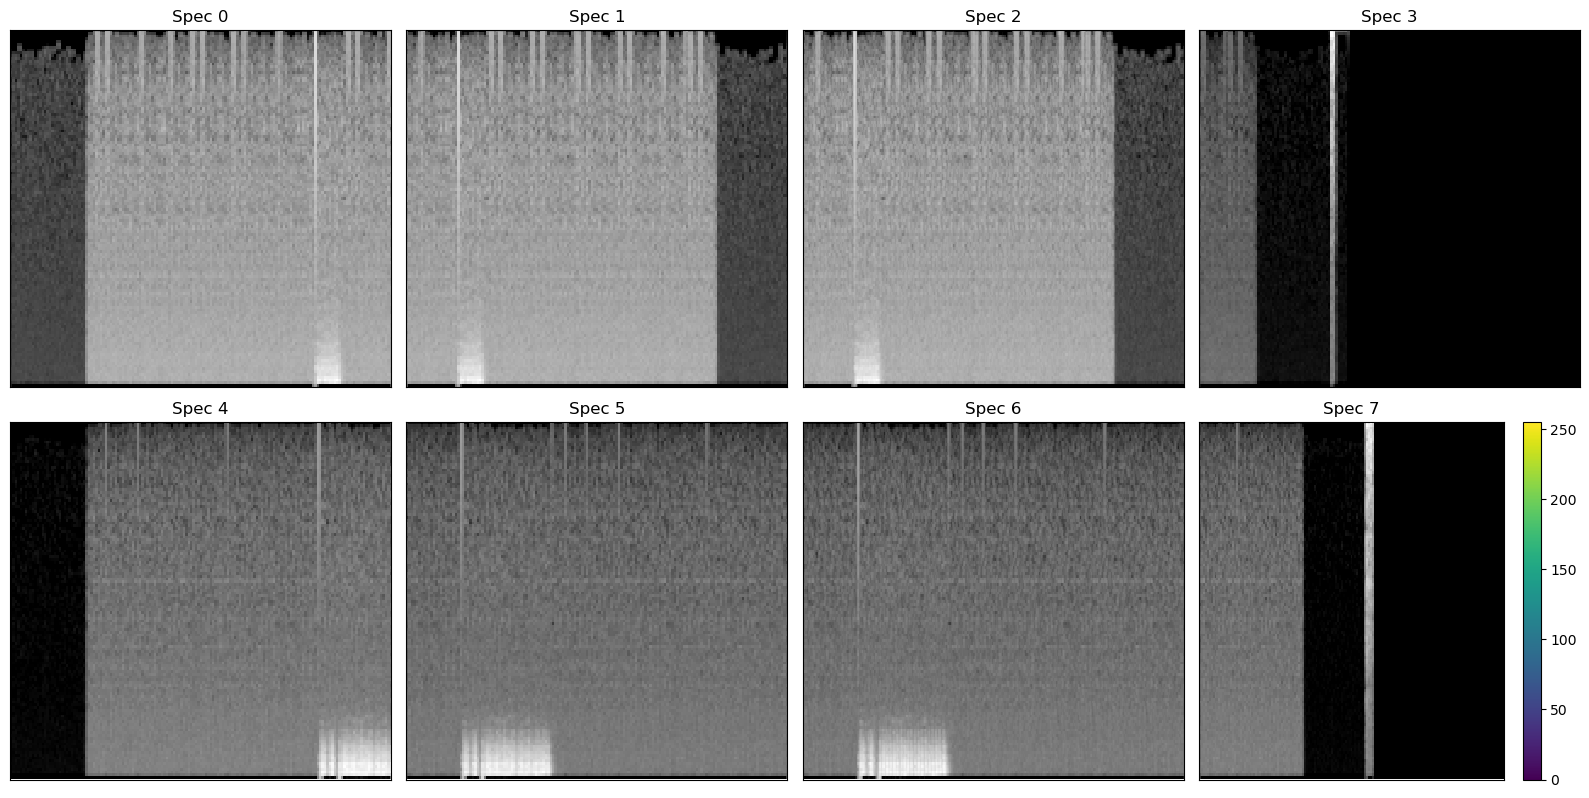

In [4]:
# Load spectrogram files from S3

bucket_name = 'cs401finalpipelineprocessingdata'
folder_path = 'data/audio_specs/1139490/'
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

spec_arrays = []
for obj in bucket.objects.filter(Prefix=folder_path):
    if obj.key.endswith('.npy'):
        print(f"Loading {obj.key}")
        
        # Get the object data
        s3_object = s3.Object(bucket_name, obj.key)
        
        # Download and load the NumPy array
        try:
            # Method 1: Using BytesIO
            file_data = BytesIO(s3_object.get()['Body'].read())
            array = np.load(file_data)
            spec_arrays.append(array)
            
            # Print shape and value range to debug
            print(f"Array shape: {array.shape}, Min: {array.min()}, Max: {array.max()}")
        except Exception as e:
            print(f"Error loading {obj.key}: {e}")

# Display the loaded spectrograms
if spec_arrays:
    show_spectrograms(spec_arrays, 8, 2, 4)
else:
    print("No spectrogram files found or loaded")

In [5]:
# going to exclude the files with very large chunk size XC941297_chunk_2.npy (include) versus XC941297_chunk_213120.npy (exclude)

# Step 2: Map scientific_name to primary_label
df_filtered['primary_label'] = df_filtered['scientific_name']

# Step 3: Create a mapping between filenames and spectrogram files
spec_mapping = {}

# Connect to S3
s3 = boto3.resource('s3')
bucket = s3.Bucket('cs401finalpipelineprocessingdata')
prefix = 'data/audio_specs/'

# Scan S3 bucket to find all spectrograms
for obj in bucket.objects.filter(Prefix=prefix):
    key_parts = obj.key.split('/')
    if len(key_parts) > 3:
        filename = key_parts[-1]
        
        # Skip non-NPY files
        if not filename.endswith('.npy'):
            continue
            
        # Extract base filename and chunk info
        try:
            base_filename = filename.split('_chunk_')[0]
            chunk_part = filename.split('_chunk_')[1]
            chunk_number = int(chunk_part.split('.')[0])
            
            # Skip files with very large chunk numbers
            if chunk_number > 1000:
                continue
                
            if base_filename not in spec_mapping:
                spec_mapping[base_filename] = []
                
            spec_mapping[base_filename].append(obj.key)
        except (IndexError, ValueError):
            continue

# Step 4: Add spectrogram paths to DataFrame
def get_spec_files(filename):
    # Extract the base filename without extension and path
    if '/' in filename:
        base = os.path.splitext(os.path.basename(filename))[0]
    else:
        base = os.path.splitext(filename)[0]
    
    return spec_mapping.get(base, [])

# Add spectrogram files to DataFrame
df_filtered['spec_files'] = df_filtered['filename'].apply(get_spec_files)

# Step 5: Filter out rows without spectrograms
df_filtered = df_filtered[df_filtered['spec_files'].apply(len) > 0]

# Step 6: Explode the dataframe so each spectrogram gets its own row
df_exploded = df_filtered[['primary_label', 'spec_files']].explode('spec_files').rename(columns={'spec_files': 's3_key'})

# Step 7: Create train/validation split
# Check if we have enough samples per class for stratification
counts = df_exploded['primary_label'].value_counts()
valid_for_stratify = counts[counts >= 2].index

if len(valid_for_stratify) > 0:
    # Filter to only use classes with at least 2 samples for stratification
    stratify_df = df_exploded[df_exploded['primary_label'].isin(valid_for_stratify)]
    
    # Split with stratification
    train_df, val_df = train_test_split(
        stratify_df, 
        test_size=0.2, 
        random_state=42, 
        stratify=stratify_df['primary_label']
    )
    
    # Add remaining samples to training set
    remaining = df_exploded[~df_exploded['primary_label'].isin(valid_for_stratify)]
    train_df = pd.concat([train_df, remaining])
else:
    # If no class has at least 2 samples, split without stratification
    train_df, val_df = train_test_split(df_exploded, test_size=0.2, random_state=42)

# Step 8: Save to CSV files
# Option 1: Save locally
train_df.to_csv('train_manifest.csv', index=False)
val_df.to_csv('val_manifest.csv', index=False)

# Option 2: Save directly to S3
s3_client = boto3.client('s3')
bucket_name = 'cs401finalpipelineprocessingdata'

for name, df in [('train_manifest.csv', train_df), ('val_manifest.csv', val_df)]:
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)
    s3_client.put_object(
        Body=csv_buffer.getvalue(),
        Bucket=bucket_name,
        Key=f'manifests/{name}'
    )

print(f"Created train manifest with {len(train_df)} entries and validation manifest with {len(val_df)} entries")

Created train manifest with 5348 entries and validation manifest with 1338 entries


In [6]:
# Now I need to make a model that uses train_manifest.csv and val_manifest.csv
# model must determine the species given the spectrograph
# The dimensions of the Spectrograph need to be channel first. 
# Array shape: (128, 157, 3) -->bad, (3, 128, 157) --> good
# On top of that, each Spectrogram has different sizes for the third axix for example, Array shape: (128, 157, 3)
class BirdSpeciesDataset(torch.utils.data.Dataset):
    def __init__(self, manifest_path, transform=None):
        self.df = pd.read_csv(manifest_path)
        self.transform = transform
        
        # Map species to indices
        self.species = sorted(self.df['primary_label'].unique())
        self.label_to_idx = {label: idx for idx, label in enumerate(self.species)}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        try:
            row = self.df.iloc[idx]
            species = row['primary_label']
            spec_path = row['s3_key']
            
            # When running in SageMaker, the data is already downloaded
            # Need to map the S3 path to local path based on how ProcessingInput configured paths
            local_path = spec_path
            if spec_path.startswith('s3://'):
                # Extract just the filename from the S3 path
                local_path = os.path.join('/opt/ml/processing/data', os.path.basename(spec_path))
            
            # Load spectrogram from file
            spec_data = np.load(local_path)
            
            # Convert to tensor
            spec_tensor = torch.tensor(spec_data, dtype=torch.float32)
            
            # Transpose from (128, width, 3) to (3, 128, width)
            if spec_tensor.shape[0] == 128 and spec_tensor.shape[2] == 3:
                spec_tensor = spec_tensor.permute(2, 0, 1)
            
            # Scale to [0-1] range
            if spec_tensor.max() > 1.0:
                spec_tensor = spec_tensor / 255.0
            
            # Apply transformations if any
            if self.transform:
                spec_tensor = self.transform(spec_tensor)
            
            # Get label index
            label_idx = self.label_to_idx[species]
            
            return spec_tensor, label_idx
            
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            # Return a dummy sample instead of crashing
            dummy_tensor = torch.zeros((3, 128, 224), dtype=torch.float32)
            return dummy_tensor, 0


In [4]:
from sagemaker.pytorch.processing import PyTorchProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
import sagemaker
import boto3
from sagemaker import get_execution_role, Session, image_uris

session = sagemaker.Session()
role = get_execution_role()

# Set up SageMaker session
sagemaker_session = sagemaker.Session()

# Configure the PyTorchProcessor
# Move the environment variable to the env parameter here
pytorch_processor = PyTorchProcessor(
    framework_version="1.13.1",  # Use the PyTorch version compatible with your code
    role=role,
    py_version="py39",
    instance_type="ml.m5.large",  # GPU instance for faster training
    instance_count=1,
    base_job_name="birdclef-training-job",
    volume_size_in_gb=100,  # Increase if you have large datasets
    sagemaker_session=sagemaker_session,
    env={"PYTHONUNBUFFERED": "1"}  # Set environment variables here instead
)

# Define input and output data locations
s3_bucket = "cs401finalpipelineprocessingdata"  # Remove the trailing space
train_manifest_uri = f"s3://{s3_bucket}/manifests/train_manifest.csv"
val_manifest_uri = f"s3://{s3_bucket}/manifests/val_manifest.csv"
output_uri = f"s3://{s3_bucket}/model-output/"

# Run the processing job
pytorch_processor.run(
    code="train_script_2.0.py",
    source_dir=".",  # Folder containing your script and requirements.txt
        inputs=[
        ProcessingInput(
            source=f"s3://{s3_bucket}/data/audio_specs",
            destination="/opt/ml/processing/data/audio_specs",
            input_name="spectrograms"
        ),
        ProcessingInput(
            source=train_manifest_uri,
            destination="/opt/ml/processing/input/train",
            input_name="train-data"
        ),
        ProcessingInput(
            source=val_manifest_uri,
            destination="/opt/ml/processing/input/validation",
            input_name="val-data"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="model-output",
            source="/opt/ml/processing/output",
            destination=output_uri
        )
    ],
    arguments=[
        "--epochs", "20",
        "--batch-size", "32",
        "--learning-rate", "0.001",
        "--accumulation-steps", "4"
    ],
    wait=True,
    logs=True
    # Remove the environment parameter from here
)

print(f"Training job completed. Model artifacts saved to {output_uri}")

[04/21/25 20:33:25] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=720715;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=412642;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

[04/21/25 20:33:36] INFO     Uploaded . to                                                       ]8;id=707900;file:///opt/conda/lib/python3.12/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=686789;file:///opt/conda/lib/python3.12/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://sagemaker-us-east-1-084375543672/birdclef-training-job-2025-04                   
                             -21-20-33-25-812/source/sourcedir.tar.gz                                              

                    INFO     runproc.sh uploaded to                                              ]8;id=534014;file:///opt/conda/lib/python3.12/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=837692;file:///opt/conda/lib/python3.12/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://sagemaker-us-east-1-084375543672/birdclef-training-job-2025-04                   
                             -21-20-33-25-812/source/runproc.sh                                                    

                    INFO     Creating processing-job with name                                      ]8;id=898487;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=407493;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1575\1575]8;;\
                             birdclef-training-job-2025-04-21-20-33-25-812                                         

................CodeArtifact repository not specified. Skipping login.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.0/214.0 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.9/377.9 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 93.6 MB/s eta 0:00:00
[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
/opt/conda/lib/python3.

In [14]:
# audio_file = 'bird_recording.ogg'
# spec_array = preprocess_audio_file(audio_file)
# result = get_bird_prediction(spec_array)

In [32]:
import os
import tarfile
import boto3

# ── CONFIG ──────────────────────────────────────────
bucket     = "cs401finalpipelineprocessingdata"
s3_prefix  = "model-output"            # where your .pth & mapping live
work_dir   = "./model_build"           # relative path in your home dir
os.makedirs(work_dir, exist_ok=True)

# ── LOCAL PATHS ────────────────────────────────────
weights_file = os.path.join(work_dir, "best_model.pth")
map_file     = os.path.join(work_dir, "species_mapping.json")
script_file  = "inference.py"          # must already be next to this notebook
req_file = "requirements.txt"

# ── S3 CLIENT ─────────────────────────────────────
s3 = boto3.client("s3")

# ── 1) DOWNLOAD FROM S3 ─────────────────────────────
print("Downloading best_model.pth …")
s3.download_file(bucket, f"{s3_prefix}/best_model.pth", weights_file)
print("Downloading species_mapping.json …")
s3.download_file(bucket, f"{s3_prefix}/species_mapping.json", map_file)

# ── 2) BUILD THE TAR ────────────────────────────────
tar_path = os.path.join(work_dir, "model_test.tar.gz")
print(f"Creating tar at {tar_path} …")
with tarfile.open(tar_path, "w:gz") as tar:
    tar.add(script_file,     arcname="code/inference.py")
    tar.add(req_file,        arcname="code/requirements.txt")
    tar.add(weights_file,    arcname="best_model.pth")
    tar.add(map_file,        arcname="species_mapping.json")

# ── 3) UPLOAD BACK TO S3 ────────────────────────────
artifact_key = "endpoint-artifacts/model_test.tar.gz"
print(f"Uploading {tar_path} to s3://{bucket}/{artifact_key} …")
s3.upload_file(tar_path, bucket, artifact_key)

model_data_uri = f"s3://{bucket}/{artifact_key}"
print(f"✔️  Tar uploaded. You can now deploy from:\n   {model_data_uri}")

Creating tar at ./model_build/model_test.tar.gz …
Uploading ./model_build/model_test.tar.gz to s3://cs401finalpipelineprocessingdata/endpoint-artifacts/model_test.tar.gz …
✔️  Tar uploaded. You can now deploy from:
   s3://cs401finalpipelineprocessingdata/endpoint-artifacts/model_test.tar.gz
Creating tar at ./model_build/model_test.tar.gz …
Uploading ./model_build/model_test.tar.gz to s3://cs401finalpipelineprocessingdata/endpoint-artifacts/model_test.tar.gz …
✔️  Tar uploaded. You can now deploy from:
   s3://cs401finalpipelineprocessingdata/endpoint-artifacts/model_test.tar.gz


In [56]:
from sagemaker.pytorch import PyTorchModel

# Path to your trained model in S3
model_data = "s3://cs401finalpipelineprocessingdata/endpoint-artifacts/model_test.tar.gz"

# Create a PyTorch model
pytorch_model = PyTorchModel(
    model_data=model_data,
    role=role,
    entry_point="inference.py",
    framework_version="1.13.1",
    py_version="py39",
    sagemaker_session=sagemaker_session,
)

# Deploy the model to an endpoint
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name="birdclef-endpoint"
)

print(f"Model deployed to endpoint: {predictor.endpoint_name}")

[04/22/25 05:49:49] INFO     Repacking model artifact                                                  ]8;id=76961;file:///opt/conda/lib/python3.12/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=860084;file:///opt/conda/lib/python3.12/site-packages/sagemaker/model.py#821\821]8;;\
                             (s3://cs401finalpipelineprocessingdata/endpoint-artifacts/model_test.tar.             
                             gz), script artifact (None), and dependencies ([]) into single tar.gz                 
                             file located at                                                                       
                             s3://sagemaker-us-east-1-084375543672/pytorch-inference-2025-04-22-05-49-             
                             49-856/model.tar.gz. This may take some time depending on model size...               

[04/22/25 05:49:52] INFO     Creating model with name: pytorch-inference-2025-04-22-05-49-52-474    ]8;id=666412;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=699260;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/22/25 05:49:53] INFO     Creating endpoint-config with name birdclef-endpoint                   ]8;id=115807;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=792349;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name birdclef-endpoint                          ]8;id=40663;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=591538;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\

---------!Model deployed to endpoint: birdclef-endpoint


In [59]:
import io, json, base64
import numpy as np

# Create dummy input
spec = (np.random.rand(128, 200, 3) * 255).astype(np.uint8)
payload = io.BytesIO()
np.save(payload, spec)
payload.seek(0)
raw_bytes = payload.read()

# Encode to base64 for JSON transport
b64 = base64.b64encode(raw_bytes).decode("utf-8")
data = {"array": b64}

# Predict — encode JSON to bytes!
response = predictor.predict(data)

print(response)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 data = {"array": b64}                                                                       │
│   14                                                                                             │
│   15 # Predict — encode JSON to bytes!                                                           │
│ ❱ 16 response = predictor.predict(data)                                                          │
│   17                                                                                             │
│   18 print(response)                                                                             │
│   19                                                                                             │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/base_predictor.py:212 in predict               │
│                                                                                                  │
│   209 │   │   if inference_component_name:                                                       │
│   210 │   │   │   request_args["InferenceComponentName"] = inference_component_name              │
│   211 │   │                                                                                      │
│ ❱ 212 │   │   response = self.sagemaker_session.sagemaker_runtime_client.invoke_endpoint(**req   │
│   213 │   │   return self._handle_response(response)                                             │
│   214 │                                                                                          │
│   215 │   def _handle_response(self, response):                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/botocore/client.py:569 in _api_call                      │
│                                                                                                  │
│    566 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    567 │   │   │   │   )                                                                         │
│    568 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  569 │   │   │   return self._make_api_call(operation_name, kwargs)                            │
│    570 │   │                                                                                     │
│    571 │   │   _api_call.__name__ = str(py_operation_name)                                       │
│    572                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/botocore/client.py:1023 in _make_api_call                │
│                                                                                                  │
│   1020 │   │   │   │   "Code"                                                                    │
│   1021 │   │   │   )                                                                             │
│   1022 │   │   │   error_class = self.exceptions.from_code(error_code)                           │
│ ❱ 1023 │   │   │   raise error_class(parsed_response, operation_name)                            │
│   1024 │   │   else:                                                                             │
│   1025 │   │   │   return parsed_response                                                        │
│   1026                                                     

In [45]:
import io
import numpy as np
import importlib.util
import json
import base64

# ── Load inference.py ──────────────────────────────
spec = importlib.util.spec_from_file_location("inference", "./inference.py")
inference = importlib.util.module_from_spec(spec)
spec.loader.exec_module(inference)

# ── Generate dummy input ───────────────────────────
spec_arr = (np.random.rand(128, 200, 3) * 255).astype(np.uint8)

buf = io.BytesIO()
np.save(buf, spec_arr)
buf.seek(0)
raw_bytes = buf.read()

b64 = base64.b64encode(raw_bytes).decode("utf-8")
data = {"array": b64}

response = predictor.predict(
    json.dumps(data),
    initial_args={"ContentType": "application/json"}
)

# ── Simulate the inference pipeline ────────────────
model = inference.model_fn("./model_build")  # adjust if your model is elsewhere
input_data = inference.input_fn(json.dumps(data), "application/json")
prediction = inference.predict_fn(input_data, model)
output, _ = inference.output_fn(prediction, "application/json")

print("Prediction Output:")
print(output)


[inference.py] model_fn called with model_dir=./model_build


/opt/conda/lib/python3.12/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


[04/22/25 05:23:29] INFO     Model loaded with 42 classes                                           ]8;id=76021;file:///home/sagemaker-user/inference.py\inference.py]8;;\:]8;id=402325;file:///home/sagemaker-user/inference.py#49\49]8;;\

[inference.py] input_fn got content_type=application/json, body_len=102585
[inference.py] predict_fn got data.shape=(128, 200, 3)
[inference.py] output_fn returning accept=application/json
Prediction Output:
{"top5_labels": ["Andinobates opisthomelas", "Allobates femoralis", "Leptodactylus savagei", "Alouatta seniculus", "Espadarana prosoblepon"], "top5_probs": [1.0, 4.829856675193922e-13, 1.6178431201208603e-16, 1.6116832053608514e-16, 5.422041283901519e-21]}
